In [1]:
import sys
refer_path = "D:\\Datasets\\refer-master\\refer-master"
img_path = refer_path+"\\data\\images\\mscoco\\images\\train2014\\"
sys.path.append(refer_path)
from refer import REFER
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pprint import pprint
import csv
import cv2
# IoU function
def computeIoU(box1, box2):
    # each box is of [x1, y1, w, h]
    inter_x1 = max(box1[0], box2[0])
    inter_y1 = max(box1[1], box2[1])
    inter_x2 = min(box1[0]+box1[2]-1, box2[0]+box2[2]-1)
    inter_y2 = min(box1[1]+box1[3]-1, box2[1]+box2[3]-1)

    if inter_x1 < inter_x2 and inter_y1 < inter_y2:
        inter = (inter_x2-inter_x1+1)*(inter_y2-inter_y1+1)
    else:
        inter = 0
    union = box1[2]*box1[3] + box2[2]*box2[3] - inter
    return float(inter)/union
    
    
data_root = refer_path + '/data'  # contains refclef, refcoco, refcoco+, refcocog and images
dataset = 'refcoco+'
splitBy = 'unc'
refer = REFER(data_root, dataset, splitBy)


ref_ids = refer.getRefIds()
print(len(ref_ids))
print (len(refer.Imgs))
print (len(refer.imgToRefs))

ref_ids = refer.getRefIds(split='train')
print ('There are %s training referred objects.' % len(ref_ids))

#initialize LSeg
import os
import argparse
import numpy as np
from tqdm import tqdm
from collections import OrderedDict

import torch
import torch.nn.functional as F
from torch.utils import data
import torchvision.transforms as transform
from torch.nn.parallel.scatter_gather import gather

import encoding.utils as utils
from encoding.nn import SegmentationLosses, SyncBatchNorm
from encoding.parallel import DataParallelModel, DataParallelCriterion
from encoding.datasets import test_batchify_fn 
from encoding.models.sseg import BaseNet
from additional_utils.models import LSeg_MultiEvalModule
from modules.lseg_module import LSegModule

import math
import types
import functools
import torchvision.transforms as torch_transforms
import copy
import itertools
from PIL import Image
import matplotlib.pyplot as plt
import clip
import matplotlib as mpl
import matplotlib.colors as mplc
import matplotlib.figure as mplfigure
import matplotlib.patches as mpatches
from matplotlib.backends.backend_agg import FigureCanvasAgg
from data import get_dataset
import torchvision.transforms as transforms

class Options:
    def __init__(self):
        parser = argparse.ArgumentParser(description="PyTorch Segmentation")
        # model and dataset
        parser.add_argument(
            "--model", type=str, default="encnet", help="model name (default: encnet)"
        )
        parser.add_argument(
            "--backbone",
            type=str,
            default="clip_vitl16_384",
            help="backbone name (default: resnet50)",
        )
        parser.add_argument(
            "--dataset",
            type=str,
            default="ade20k",
            help="dataset name (default: pascal12)",
        )
        parser.add_argument(
            "--workers", type=int, default=16, metavar="N", help="dataloader threads"
        )
        parser.add_argument(
            "--base-size", type=int, default=520, help="base image size"
        )
        parser.add_argument(
            "--crop-size", type=int, default=480, help="crop image size"
        )
        parser.add_argument(
            "--train-split",
            type=str,
            default="train",
            help="dataset train split (default: train)",
        )
        parser.add_argument(
            "--aux", action="store_true", default=False, help="Auxilary Loss"
        )
        parser.add_argument(
            "--se-loss",
            action="store_true",
            default=False,
            help="Semantic Encoding Loss SE-loss",
        )
        parser.add_argument(
            "--se-weight", type=float, default=0.2, help="SE-loss weight (default: 0.2)"
        )
        parser.add_argument(
            "--batch-size",
            type=int,
            default=16,
            metavar="N",
            help="input batch size for \
                            training (default: auto)",
        )
        parser.add_argument(
            "--test-batch-size",
            type=int,
            default=16,
            metavar="N",
            help="input batch size for \
                            testing (default: same as batch size)",
        )
        # cuda, seed and logging
        parser.add_argument(
            "--no-cuda",
            action="store_true",
            default=False,
            help="disables CUDA training",
        )
        parser.add_argument(
            "--seed", type=int, default=1, metavar="S", help="random seed (default: 1)"
        )
        # checking point
        parser.add_argument(
            "--weights", type=str, default='', help="checkpoint to test"
        )
        # evaluation option
        parser.add_argument(
            "--eval", action="store_true", default=False, help="evaluating mIoU"
        )
        parser.add_argument(
            "--export",
            type=str,
            default=None,
            help="put the path to resuming file if needed",
        )
        parser.add_argument(
            "--acc-bn",
            action="store_true",
            default=False,
            help="Re-accumulate BN statistics",
        )
        parser.add_argument(
            "--test-val",
            action="store_true",
            default=False,
            help="generate masks on val set",
        )
        parser.add_argument(
            "--no-val",
            action="store_true",
            default=False,
            help="skip validation during training",
        )

        parser.add_argument(
            "--module",
            default='lseg',
            help="select model definition",
        )

        # test option
        parser.add_argument(
            "--data-path", type=str, default='../datasets/', help="path to test image folder"
        )

        parser.add_argument(
            "--no-scaleinv",
            dest="scale_inv",
            default=True,
            action="store_false",
            help="turn off scaleinv layers",
        )

        parser.add_argument(
            "--widehead", default=False, action="store_true", help="wider output head"
        )

        parser.add_argument(
            "--widehead_hr",
            default=False,
            action="store_true",
            help="wider output head",
        )
        parser.add_argument(
            "--ignore_index",
            type=int,
            default=-1,
            help="numeric value of ignore label in gt",
        )
        
        parser.add_argument(
            "--label_src",
            type=str,
            default="default",
            help="how to get the labels",
        )
        
        parser.add_argument(
            "--arch_option",
            type=int,
            default=0,
            help="which kind of architecture to be used",
        )

        parser.add_argument(
            "--block_depth",
            type=int,
            default=0,
            help="how many blocks should be used",
        )

        parser.add_argument(
            "--activation",
            choices=['lrelu', 'tanh'],
            default="lrelu",
            help="use which activation to activate the block",
        )

        self.parser = parser

    def parse(self):
        args = self.parser.parse_args(args=[]) 
        args.cuda = not args.no_cuda and torch.cuda.is_available()
        print(args)
        return args
    


# If image path and f/q is not passed as command
# line arguments, quit and display help message
#if len(sys.argv) < 3:
#    print(__doc__)
#    sys.exit(1)
def ssearch(img_path, bbox, min_size):
    print(min_size)
    rects = []
    # speed-up using multithreads
    cv2.setUseOptimized(True);
    cv2.setNumThreads(4);
    top_left = (bbox[0],bbox[1])
    # read image
    im = cv2.imread(img_path)[bbox[1]:bbox[3],bbox[0]:bbox[2]]
    #cv2.imshow("test", im)
    #print(im)

    # create Selective Search Segmentation Object using default parameters
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

    # set input image on which we will run segmentation
    ss.setBaseImage(im)


    #ss.switchToSelectiveSearchQuality()
    ss.switchToSelectiveSearchFast()

    # run selective search segmentation on input image
    temp_rects = ss.process() #xywh
    for rect in temp_rects:
        if boxSize_xywh(rect)>min_size: #remove box if too small
            temp_rect = [0,0,0,0]
            temp_rect[0] = rect[0]+top_left[0]
            temp_rect[1] = rect[1]+top_left[1]
            temp_rect[2] = temp_rect[0]+rect[2]
            temp_rect[3] = temp_rect[1]+rect[3]
            rects.append(temp_rect)
    print('Total Number of Region Proposals: {}'.format(len(rects)))


    # number of region proposals to show
    numShowRects = 100
    # increment to increase/decrease total number
    # of reason proposals to be shown
    increment = 50
    return rects
    
    
def get_new_pallete(num_cls):
    n = num_cls
    pallete = [0]*(n*3)
    for j in range(0,n):
            lab = j
            pallete[j*3+0] = 0
            pallete[j*3+1] = 0
            pallete[j*3+2] = 0
            i = 0
            while (lab > 0):
                    pallete[j*3+0] |= (((lab >> 0) & 1) << (7-i))
                    pallete[j*3+1] |= (((lab >> 1) & 1) << (7-i))
                    pallete[j*3+2] |= (((lab >> 2) & 1) << (7-i))
                    i = i + 1
                    lab >>= 3
    return pallete

def get_new_mask_pallete(npimg, new_palette, out_label_flag=False, labels=None):
    """Get image color pallete for visualizing masks"""
    # put colormap
    out_img = Image.fromarray(npimg.squeeze().astype('uint8'))
    out_img.putpalette(new_palette)

    if out_label_flag:
        assert labels is not None
        u_index = np.unique(npimg)
        patches = []
        for i, index in enumerate(u_index):
            label = labels[index]
            cur_color = [new_palette[index * 3] / 255.0, new_palette[index * 3 + 1] / 255.0, new_palette[index * 3 + 2] / 255.0]
            red_patch = mpatches.Patch(color=cur_color, label=label)
            patches.append(red_patch)
    return out_img, patches

#Draw Rectangle on input canvas
def draw_rectangle(draw, coordinates, color, width=1):
    for i in range(width):
        rect_start = (coordinates[0][0] - i, coordinates[0][1] - i)
        rect_end = (coordinates[1][0] + i, coordinates[1][1] + i)
        draw.rectangle((rect_start, rect_end), outline = color)
#Compare if pixel A and B are the same, return true if same
def comparePixel(pxA,pxB):
    for i in range(len(pxA)):
       # print(type(pxA))
       # print(type(pxB))
        if pxA[i] != pxB[i]:
            return False
    return True

#Convert the palette used in lseg into rgba for easier computation
def palette_to_rgba(new_palette):
    colors = [] 
    for i in range(2,len(new_palette),3): #new_pallete is a contiguous tuple of rgb values
        colors.append([new_palette[i-2],new_palette[i-1],new_palette[i]])
    rgba_cols = []
    for color in colors:
        color.append(255)
        rgba_cols.append(np.array(color))
    return rgba_cols #colors of each label for the segmap
#Break the singular segmap into multiple maps for each input label, and generate a single bounding box for each label
#Each generated segmap will have transparency for pixels that are not of the label
def process_segmap(rgba_cols, seg):
    bboxes = []
    segmaps = []

    for rgba_col in rgba_cols:
        test_seg = np.array(seg).copy()
        xmin = ymin = 99999
        xmax = ymax = 0
        #separate the segments, put in a larger loop for each label
        for col in range(0,len(test_seg)):
            #print(row)
            for row in range(0,len(test_seg[col])):
                if not comparePixel(test_seg[col][row],rgba_col):
                    test_seg[col][row] = [0,0,0,0] #make transparent
                else: #get top left and bottom right to draw rectangle
                    if row>xmax:
                        xmax = row
                    if col>ymax:
                        ymax = col
                    if row<xmin:
                        xmin = row
                    if col<ymin:
                        ymin = col
        bboxes.append([xmin,ymin,xmax,ymax])
        segmaps.append(test_seg)
    return bboxes, segmaps
    #Image.fromarray(test_seg)
    
#Function to find the gap within the existing bounding box
#Returns 2 arrays indicating the range or horizontal gap and vertical gap
#Values in the array can be used to identify how to split the bounding boxes
#Eg. Return value [sx1,sx2] indicates the split starts from x=sx1, y=y and ends at x=sx2, y=y

def contiguous_transparency_scan(box,segmap,instance_threshold=0):
    #iterative vertical scan (left to right scan every column)
    min_x = max_x = -1
    for x in range(box[0],box[2]):
        isContiguous = True #whether it is a contiguous transparent block
        count_colored = 0
        for y in range(box[1],box[3]):
            #print(x,y)
            if not comparePixel(segmap[y][x],[0,0,0,0]):
                count_colored+=1
                if count_colored>instance_threshold:
                    isContiguous = False
                    break
        if isContiguous:
            #print(x)
            if min_x==-1:
                min_x = x
                max_x = min_x
            else:
                max_x +=1
        else:
            if max_x - min_x > 0:
                break
    #iterative horizontal scan (top to bottom scan every row)
    min_y = max_y = -1
    for y in range(box[1],box[3]):
        isContiguous = True
        count_colored = 0
        for x in range(box[0],box[2]):
            if not comparePixel(segmap[y][x],[0,0,0,0]):
                count_colored+=1
                if count_colored>=instance_threshold:
                    isContiguous = False
                    break
                #isContiguous = False
                #break
        if isContiguous:
            if min_y==-1:
                min_y = y
                max_y = min_y
            else:
                max_y +=1
        else:
            if max_y - min_y > 0:
                break
    #if max_x - min_x>0 or arbitary threshold means there is a gap in the segmentation
    # if the above is true, that means the bounding box can be instanced into a left and right instance
    # if max_y - min_y >0 or arbitary threshold, means thee boundingbox can be instanced into a top and bottom instance
    return [min_x,max_x],[min_y,max_y]

#Optimize the new boxes to fit nicely around the segment instance, split bounding boxes tend to be larger than segment
def optimizeBoxes(bbox,segmap):
    new_boxes = []

    for box in bbox:
        xmin = ymin = 99999
        xmax = ymax = 0
        for col in range(box[0],box[2]):
            for row in range(box[1],box[3]):
                if not comparePixel(segmap[row][col], [0,0,0,0]):
                    if col>xmax:
                        xmax = col
                    if row>ymax:
                        ymax = row
                    if col<xmin:
                        xmin = col
                    if row<ymin:
                        ymin = row
        if [xmin,ymin,xmax,ymax] != [99999,99999,0,0]:
            new_boxes.append([xmin,ymin,xmax,ymax])
        else:
            new_boxes.append(box)

    return new_boxes

#Split boxes and optimize
def splitBox(box,x_split, y_split, segmap):
    bbox = []
    if x_split[0]==-1 and y_split[0]==-1:
        return
    elif x_split[0]==-1:
        #splt top and bottom
        top_box = [box[0],y_split[0],box[2],box[3]]
        bot_box = [box[0],box[1],box[2],y_split[1]]
        #bbox = [top_box,bot_box]
        bbox = optimizeBoxes([top_box,bot_box],segmap)
    else:
        #split left and right
        left_box = [box[0],box[1],x_split[0],box[3]]
        right_box = [x_split[1],box[1],box[2],box[3]]
        #bbox = [left_box,right_box]
        bbox = optimizeBoxes([left_box,right_box],segmap)
    return bbox
    
#Return box size in area
def boxSize(box):
    x = box[2]-box[0]
    y = box[3]-box[1]
    return x*y

def boxSize_xywh(box):
    return box[2]*box[3]
    
#Return max similarity value for each variable
def boxSimilarity(box1,box2):
    x1 = abs(box2[0]-box1[0])
    y1 = abs(box2[1]-box1[1])
    x2 = abs(box2[2]-box1[2])
    y2 = abs(box2[3]-box1[3])
    return max([x1,y1,x2,y2])
    
#Main function to instance the segmentation map based on horizontal and verticle gaps, as well as optimize the size
#boxes that are too similar or too small are also filtered out along the way
def bbox_instancing(bboxes,segmaps,min_size = 5):
    final_instances = []
    for idx in range(len(bboxes)): #number of classes
        box = bboxes[idx]
        segmap = segmaps[idx]

        box_instances = []
        instanced_boxes = [box]
        i = 0
        #iteratively instance boxes repeatedly until boxes cannot be instanced further
        while(i<len(instanced_boxes)):
            x_contiguous,y_contiguous = contiguous_transparency_scan(instanced_boxes[i],segmap,instance_threshold=0)
            #x_contiguous,y_contiguous = segmap_instancing(instanced_boxes[i],segmap,instance_threshold=0)
            #print (x_contiguous)
            new_bboxes = splitBox(instanced_boxes[i],x_contiguous,y_contiguous,segmap)
            #print(new_bboxes)
            if new_bboxes != None:
                new_count = 0
                instanced_boxes.pop(i) #remove the box that got split into 2 instances first
                i-=1
                for new_box in new_bboxes:
                    #append the instances only if it meets the minimum size requirement
                    if boxSize(new_box)>min_size:
                        instanced_boxes.append(new_box)
                        new_count+=1
                #if new_count>0: #if at least one new box is added

            i+=1
        #filter out similar boxes that are adjacent
        i=0
        while(i<len(instanced_boxes)-1):

            sim = boxSimilarity(instanced_boxes[i],instanced_boxes[i+1])
            if (sim<5): #too similar
                #print(instanced_boxes[i],instanced_boxes[i+1])
                # remove smaller box
                if boxSize(instanced_boxes[i])>boxSize(instanced_boxes[i+1]):
                    instanced_boxes.pop(i+1)
                else:
                    instanced_boxes.pop(i)
                i-=1
            i+=1
        final_instances.append(instanced_boxes)
    return final_instances
    
args = Options().parse()

torch.manual_seed(args.seed)
args.test_batch_size = 1 
alpha=0.5
    
args.scale_inv = False
args.widehead = True
args.dataset = 'ade20k'
args.backbone = 'clip_vitl16_384'
args.weights = 'checkpoints/demo_e200.ckpt'
args.ignore_index = 255

module = LSegModule.load_from_checkpoint(
    checkpoint_path=args.weights,
    data_path=args.data_path,
    dataset=args.dataset,
    backbone=args.backbone,
    aux=args.aux,
    num_features=256,
    aux_weight=0,
    se_loss=False,
    se_weight=0,
    base_lr=0,
    batch_size=1,
    max_epochs=0,
    ignore_index=args.ignore_index,
    dropout=0.0,
    scale_inv=args.scale_inv,
    augment=False,
    no_batchnorm=False,
    widehead=args.widehead,
    widehead_hr=args.widehead_hr,
    map_locatin="cpu",
    arch_option=0,
    block_depth=0,
    activation='lrelu',
)

input_transform = module.val_transform

# dataloader
loader_kwargs = (
    {"num_workers": args.workers, "pin_memory": True} if args.cuda else {}
)

# model
if isinstance(module.net, BaseNet):
    model = module.net
else:
    model = module
    
model = model.eval()
model = model.cpu()
scales = (
    [0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25]
    if args.dataset == "citys"
    else [0.5, 0.75, 1.0, 1.25, 1.5, 1.75]
)  

model.mean = [0.5, 0.5, 0.5]
model.std = [0.5, 0.5, 0.5]

evaluator = LSeg_MultiEvalModule(
    model, scales=scales, flip=True
).cuda()
evaluator.eval()



#initialize CLIP

import clip

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

counter = 0
checkpoint = 0 # enter last index in iou log

#loop

loading dataset refcoco+ into memory...
creating index...
index created.
done
49856
19992
19992
There are 42278 training referred objects.


C:\Users\bater\anaconda3\envs\lseg37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Namespace(acc_bn=False, activation='lrelu', arch_option=0, aux=False, backbone='clip_vitl16_384', base_size=520, batch_size=16, block_depth=0, crop_size=480, cuda=True, data_path='../datasets/', dataset='ade20k', eval=False, export=None, ignore_index=-1, label_src='default', model='encnet', module='lseg', no_cuda=False, no_val=False, scale_inv=True, se_loss=False, se_weight=0.2, seed=1, test_batch_size=16, test_val=False, train_split='train', weights='', widehead=False, widehead_hr=False, workers=16)
** Use norm [0.5, 0.5, 0.5], [0.5, 0.5, 0.5] as the mean and std **
{'base_size': 520, 'crop_size': 480}
train
BaseDataset: base_size 520, crop_size 480
len(img_paths): 20210
val


C:\Users\bater\anaconda3\envs\lseg37\lib\site-packages\deprecate\deprecation.py:115: LightningDeprecationWarning: The `Accuracy` was deprecated since v1.3.0 in favor of `torchmetrics.classification.accuracy.Accuracy`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)


MultiEvalModule: base_size 520, crop_size 480


In [24]:
ref_id = ref_ids[91]
#if counter<=(checkpoint+2): #somehow need to add +2 to checkpoint to resume
#    counter+=1
#    continue
ref = refer.loadRefs(ref_id)[0]
image_id = refer.getImgIds(ref_id)[0]
#if len(ref['sentences']) < 2:
#    continue

pprint(ref)
print ('LSeg label %s.' % refer.Cats[ref['category_id']]) #pass to lseg
args.label_src = refer.Cats[ref['category_id']] + ",others"

{'ann_id': 1055111,
 'category_id': 56,
 'file_name': 'COCO_train2014_000000580718_0.jpg',
 'image_id': 580718,
 'ref_id': 104,
 'sent_ids': [295, 296, 297],
 'sentences': [{'raw': 'big piece of broccoli',
                'sent': 'big piece of broccoli',
                'sent_id': 295,
                'tokens': ['big', 'piece', 'of', 'broccoli']},
               {'raw': 'broccli',
                'sent': 'broccli',
                'sent_id': 296,
                'tokens': ['broccli']},
               {'raw': 'broccoli on plate',
                'sent': 'broccoli on plate',
                'sent_id': 297,
                'tokens': ['broccoli', 'on', 'plate']}],
 'split': 'train'}
LSeg label broccoli.


** Input label value: broccoli,others **
** MultiEvalModule parallel_forward phase: ['broccoli', 'others'] **
** MultiEvalModule forward phase: ['broccoli', 'others'] **


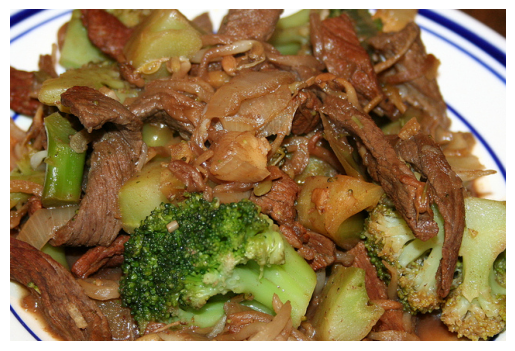

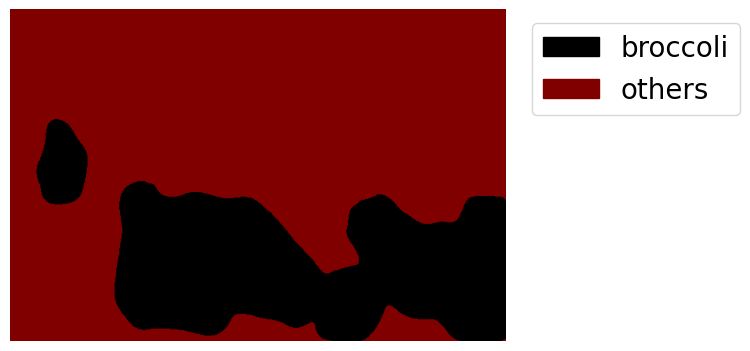

In [23]:
#LSEG Running
labels = []
print('** Input label value: {} **'.format(args.label_src))
lines = args.label_src.split(',')
for line in lines:
    label = line
    labels.append(label)
#labels.append("others")

#try:
#load image
#crop_size = 480
padding = [0.0] * 3
image = Image.open(img_path+refer.loadImgs(image_id)[0]['file_name'])
#plt.imshow(image)
image = np.array(image)
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)
image = transform(image).unsqueeze(0)
img = image[0].permute(1,2,0)
img = img * 0.5 + 0.5
#plt.imshow(img)


with torch.no_grad():
    outputs = evaluator.parallel_forward(image, labels) #evaluator.forward(image, labels) #parallel_forward
    #outputs = model(image,labels)
    predicts = [
        torch.max(output, 1)[1].cpu().numpy() 
        for output in outputs
    ]
#Lseg results    
predict = predicts[0]

new_palette = get_new_pallete(len(labels))
mask, patches = get_new_mask_pallete(predict, new_palette, out_label_flag=True, labels=labels)
img = image[0].permute(1,2,0)
img = img * 0.5 + 0.5
img = Image.fromarray(np.uint8(255*img)).convert("RGBA")
seg = mask.convert("RGBA")
out = Image.blend(img, seg, alpha)
plt.axis('off')
plt.imshow(img)
plt.figure()
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
plt.axis('off')
plt.imshow(seg)

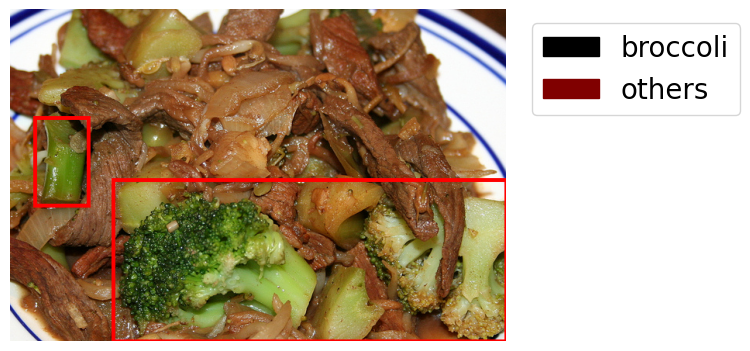

In [32]:
#get bbox
rgba_cols = palette_to_rgba(new_palette)
bboxes, segmaps = process_segmap(rgba_cols,seg)

#Show results of bounding boxes
from PIL import Image, ImageDraw
img_copy = img.copy()
#for i in range(0,len(bboxes)-1):
#    topLeft = (bboxes[i][0],bboxes[i][1])
#    bottomRight = (bboxes[i][2],bboxes[i][3])
#    img1 = ImageDraw.Draw(img_copy)
#    rect_color = getHexColor(rgba_cols[i])
#    draw_rectangle(img1, (topLeft,bottomRight),color = tuple(rgba_cols[i]), width=5)
#plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
#plt.axis('off')
#plt.imshow(img_copy)

w,h = img.size
min_size = w*h*0.005 #arbitary min size, 0.005 for the cat human image
new_bbox = bbox_instancing(bboxes,segmaps,min_size=min_size) 

#sample bbox instancing result
img_copy_test = img.copy()
for i in range(len(new_bbox)-1):
    for j in range(len(new_bbox[i])):
        topLeft = (new_bbox[i][j][0],new_bbox[i][j][1])
        bottomRight = (new_bbox[i][j][2],new_bbox[i][j][3])
        img1 = ImageDraw.Draw(img_copy_test)
        #rect_color = getHexColor(rgba_cols[i])
        draw_rectangle(img1, (topLeft,bottomRight),color = "red", width=5)
        #draw_rectangle(img1, (topLeft,bottomRight),color = "red", width=2)
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
plt.axis('off')
plt.imshow(img_copy_test)

In [25]:




img_copy_clip = Image.open(img_path+refer.loadImgs(image_id)[0]['file_name'])
img_copy_clip = np.array(img_copy_clip)
cropped_imgs = []
for class_bbox in new_bbox:
    cropped_imgs.append([])
    for bbox in class_bbox:
        cropped_imgs[len(cropped_imgs)-1].append(img_copy_clip[bbox[1]:bbox[3],bbox[0]:bbox[2]])



for cls in cropped_imgs:
    for i in range(len(cls)):
        #img_transform = transform(cls[i]).unsqueeze(0)
        #print(cls[i])
        cls[i]=Image.fromarray(cls[i])


vote_arr = [0]*len(new_bbox[0])

for sentence in ref['sentences']:          
    max_score = 0
    best_id = -1
    ret_index_temp = []
    ret_index_cls = []
    #print("number of cropped: "+ str(len(cropped_imgs[0])))
    for j in range(len(cropped_imgs[0])): #for each cropped_image run it through clip with the label of description and get the highest scoring boxes
        #image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)
        image = preprocess(cropped_imgs[0][j]).unsqueeze(0).to(device)
        #text = clip.tokenize(["person in blue", "person in white", "person in red"]).to(device)
        text = clip.tokenize([sentence['sent'], "other"]).to(device)  #extracted input is also based on class
        with torch.no_grad():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text)

            logits_per_image, logits_per_text = model(image, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()

        print("Box "+str(j)+": "+str(probs[0][0]))
        #if score is higher than max, max = score and append to list. if score within 0.1 of max score, append as well
        if probs[0][0]>max_score:
            max_score = probs[0][0]
            best_id = j
    vote_arr[best_id]+=max_score

#print(vote_arr)
best_bbox = vote_arr.index(max(vote_arr)) #narrow down 1 box in the instance first, then use region proposal within that box

Box 0: 0.85
Box 1: 0.9473
Box 0: 0.953
Box 1: 0.824
Box 0: 0.905
Box 1: 0.995


In [32]:
vote_arr

[0.08416748046875, 0.99609375]

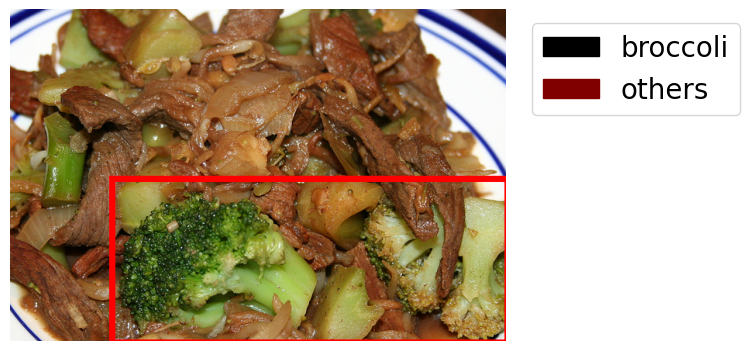

In [26]:
#draw results from clip
from PIL import Image, ImageDraw
img_copy_test2 = img.copy()
#print("clip retval: " + str(best_bbox))
#print((processed_new_bbox[i][j]))
topLeft = (new_bbox[0][best_bbox][0],new_bbox[0][best_bbox][1])
bottomRight = (new_bbox[0][best_bbox][2],new_bbox[0][best_bbox][3])
img2 = ImageDraw.Draw(img_copy_test2)
#rect_color = getHexColor(rgba_cols[i])
draw_rectangle(img2, (topLeft,bottomRight),color = "red", width=8)
new_bbox_xywh = [topLeft[0], topLeft[1], bottomRight[0]-topLeft[0], bottomRight[1]-topLeft[1]]
#ref_bbox = refer.refToAnn[ref_id]['bbox']
#IoU = computeIoU(ref_bbox, new_bbox_xywh)
#print("IoU:"+str(IoU))
#draw_rectangle(img1, (topLeft,bottomRight),color = "red", width=2)
plt.axis('off')
plt.imshow(img_copy_test2)
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})

In [27]:
#####REGION PROPOSAL########

prop_rects = ssearch(img_path+refer.loadImgs(image_id)[0]['file_name'], new_bbox[0][best_bbox], min_size) #uninstanced bboxes, use the best box and perform region proposal
img_copy_test = Image.open(img_path+refer.loadImgs(image_id)[0]['file_name'])
#print(prop_rects)
count = 0

best_bbox = -1

padding = [0.0] * 3
img_copy_clip = Image.open(img_path+refer.loadImgs(image_id)[0]['file_name'])
#print(type(img_copy_clip))
img_copy_clip = np.array(img_copy_clip)

cropped_imgs = [[]]


for bbox in prop_rects:
    #print(bbox)
    cropped_imgs[0].append(Image.fromarray(img_copy_clip[bbox[1]:bbox[3],bbox[0]:bbox[2]]))


vote_arr = []

best_id = -1


1369.6000000000001
Total Number of Region Proposals: 468


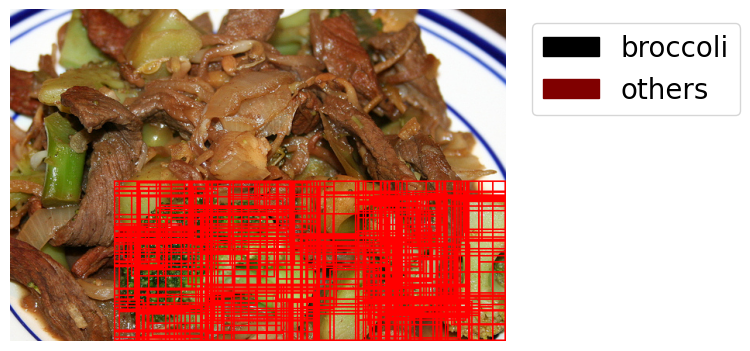

In [28]:

for rect in prop_rects:
    #print((processed_new_bbox[i][j]))
    topLeft = (rect[0],rect[1])
    bottomRight = (rect[2],rect[3])
    img1 = ImageDraw.Draw(img_copy_test)
    #rect_color = getHexColor(rgba_cols[i])
    #draw_rectangle(img1, (topLeft,bottomRight),color = tuple(rgba_cols[0]), width=5)
    draw_rectangle(img1, (topLeft,bottomRight),color = "red", width=2)
    count+=1
    if count>1000:
        break
plt.axis('off')
plt.imshow(img_copy_test)
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
#print("Input: "+user_input)
#bboxes

In [29]:
for sentence in ref['sentences']:          
    max_score = 0
    ret_index_temp = []
    ret_index_cls = []
    #print("number of cropped: "+ str(len(cropped_imgs[0])))
    for j in range(len(cropped_imgs[0])): #for each cropped_image run it through clip with the label of description and get the highest scoring boxes
        #print(j)
        #image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)
        image = preprocess(cropped_imgs[0][j]).unsqueeze(0).to(device)
        #text = clip.tokenize(["person in blue", "person in white", "person in red"]).to(device)
        text = clip.tokenize([sentence['sent'], "other"]).to(device)  #extracted input is also based on class
        with torch.no_grad():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text)

            logits_per_image, logits_per_text = model(image, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()

        print("Box "+str(j)+": "+str(probs[0][0]))
        #if score is higher than max, max = score and append to list. if score within 0.1 of max score, append as well
        if probs[0][0]>max_score:
            max_score = probs[0][0]
            best_id = j
    if best_id not in vote_arr:
        vote_arr.append(best_id)
    #else:
    #    break


Box 0: 0.9824
Box 1: 0.9565
Box 2: 0.8706
Box 3: 0.9985
Box 4: 0.9307
Box 5: 0.982
Box 6: 0.6
Box 7: 0.998
Box 8: 0.9995
Box 9: 0.766
Box 10: 0.5117
Box 11: 0.994
Box 12: 0.803
Box 13: 0.4417
Box 14: 0.991
Box 15: 0.887
Box 16: 0.902
Box 17: 0.2227
Box 18: 0.9443
Box 19: 0.793
Box 20: 0.63
Box 21: 0.655
Box 22: 0.504
Box 23: 0.95
Box 24: 0.923
Box 25: 0.7373
Box 26: 0.997
Box 27: 0.3887
Box 28: 0.152
Box 29: 0.4495
Box 30: 0.999
Box 31: 0.9707
Box 32: 0.9746
Box 33: 0.7773
Box 34: 0.5
Box 35: 0.4766
Box 36: 0.644
Box 37: 0.8965
Box 38: 0.9434
Box 39: 0.558
Box 40: 0.2878
Box 41: 0.585
Box 42: 0.752
Box 43: 0.7827
Box 44: 0.4648
Box 45: 0.992
Box 46: 0.9644
Box 47: 0.999
Box 48: 0.8057
Box 49: 0.788
Box 50: 0.9995
Box 51: 0.9033
Box 52: 0.248
Box 53: 0.808
Box 54: 0.8354
Box 55: 0.959
Box 56: 0.9844
Box 57: 0.948
Box 58: 0.995
Box 59: 0.9263
Box 60: 0.9365
Box 61: 0.9473
Box 62: 0.9854
Box 63: 0.85
Box 64: 0.5776
Box 65: 0.8457
Box 66: 0.994
Box 67: 0.98
Box 68: 0.4377
Box 69: 0.8354
Bo

Box 79: 0.9253
Box 80: 0.876
Box 81: 0.9243
Box 82: 0.916
Box 83: 0.648
Box 84: 0.1993
Box 85: 0.86
Box 86: 0.749
Box 87: 0.7905
Box 88: 0.8174
Box 89: 0.976
Box 90: 0.749
Box 91: 0.7026
Box 92: 0.9487
Box 93: 0.9307
Box 94: 0.848
Box 95: 0.991
Box 96: 0.9644
Box 97: 0.8975
Box 98: 0.7188
Box 99: 0.8774
Box 100: 0.785
Box 101: 0.676
Box 102: 0.615
Box 103: 0.6074
Box 104: 0.9565
Box 105: 0.686
Box 106: 0.3381
Box 107: 0.881
Box 108: 0.9346
Box 109: 0.637
Box 110: 0.9272
Box 111: 0.8887
Box 112: 0.9346
Box 113: 0.9795
Box 114: 0.648
Box 115: 0.9336
Box 116: 0.709
Box 117: 0.84
Box 118: 0.7637
Box 119: 0.803
Box 120: 0.637
Box 121: 0.74
Box 122: 0.1919
Box 123: 0.8457
Box 124: 0.922
Box 125: 0.9854
Box 126: 0.8633
Box 127: 0.9546
Box 128: 0.9487
Box 129: 0.585
Box 130: 0.7373
Box 131: 0.331
Box 132: 0.922
Box 133: 0.9004
Box 134: 0.9443
Box 135: 0.874
Box 136: 0.915
Box 137: 0.8223
Box 138: 0.9844
Box 139: 0.8438
Box 140: 0.3345
Box 141: 0.978
Box 142: 0.7905
Box 143: 0.8613
Box 144: 0.9

Box 154: 0.96
Box 155: 0.9946
Box 156: 0.9263
Box 157: 0.9473
Box 158: 0.457
Box 159: 0.731
Box 160: 0.662
Box 161: 0.3667
Box 162: 0.8965
Box 163: 0.9365
Box 164: 0.9995
Box 165: 0.999
Box 166: 0.9995
Box 167: 0.9033
Box 168: 0.989
Box 169: 0.693
Box 170: 0.615
Box 171: 0.911
Box 172: 1.0
Box 173: 0.9995
Box 174: 0.946
Box 175: 0.6895
Box 176: 0.997
Box 177: 0.9893
Box 178: 0.994
Box 179: 0.9907
Box 180: 0.9795
Box 181: 0.9995
Box 182: 0.9863
Box 183: 0.9805
Box 184: 0.985
Box 185: 0.8975
Box 186: 0.829
Box 187: 0.973
Box 188: 0.9565
Box 189: 0.9976
Box 190: 0.9775
Box 191: 0.1277
Box 192: 0.971
Box 193: 0.562
Box 194: 0.2598
Box 195: 0.9844
Box 196: 0.988
Box 197: 0.766
Box 198: 0.785
Box 199: 0.956
Box 200: 0.4263
Box 201: 0.808
Box 202: 0.9995
Box 203: 0.954
Box 204: 0.9243
Box 205: 1.0
Box 206: 0.996
Box 207: 0.504
Box 208: 0.968
Box 209: 0.86
Box 210: 0.8887
Box 211: 0.921
Box 212: 1.0
Box 213: 0.08154
Box 214: 0.947
Box 215: 0.4922
Box 216: 0.644
Box 217: 1.0
Box 218: 0.999
Box 

In [30]:
vote_arr
#best_id = 585

[75, 334, 3]

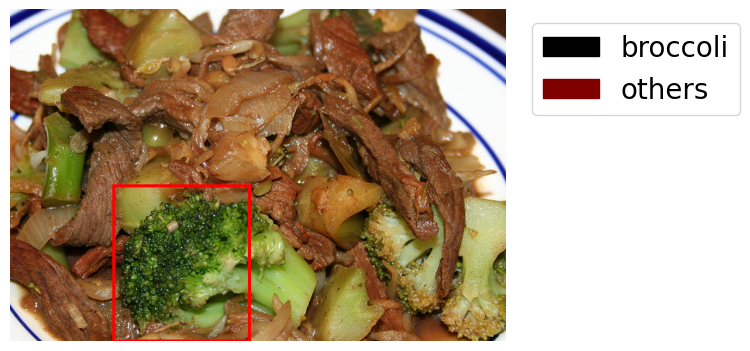

In [34]:
from PIL import Image, ImageDraw
img_copy_test = img.copy()

#idx = best_id
#print((processed_new_bbox[i][j]))
topLeft_new = [99999999,9999999]
botRight_new = [-1,-1]

for box_id in vote_arr:
    #print(prop_rects[box_id])
    if prop_rects[box_id][0]<topLeft_new[0]:
        topLeft_new[0] = prop_rects[box_id][0]
    if prop_rects[box_id][1]<topLeft_new[1]:
        topLeft_new[1] = prop_rects[box_id][1]
    if prop_rects[box_id][2]>botRight_new[0]:
        botRight_new[0] = prop_rects[box_id][2]
    if prop_rects[box_id][3]>botRight_new[1]:
        botRight_new[1] = prop_rects[box_id][3]
final_bbox = [topLeft_new[0], topLeft_new[1], botRight_new[0],botRight_new[1]]
final_bbox
img2 = ImageDraw.Draw(img_copy_test)
#rect_color = getHexColor(rgba_cols[i])
#draw_rectangle(img2, (topLeft_new,botRight_new),color = tuple(rgba_cols[i]), width=4)
draw_rectangle(img2, (topLeft_new,botRight_new),color = "red", width=4)
plt.axis('off')
plt.imshow(img_copy_test)
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
#**TODO** IOU, remember to check for size difference
#plt.figure()
#refer.showRef(ref, seg_box='box')
#plt.show()

1. big piece of broccoli
2. broccli
3. broccoli on plate


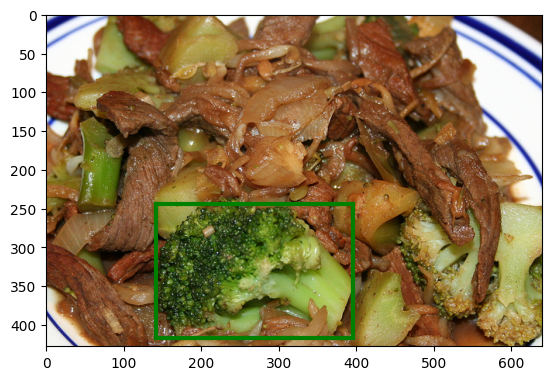

In [33]:
plt.figure()
refer.showRef(ref, seg_box='box')
plt.show()

In [11]:
new_bbox_xywh = [topLeft_new[0], topLeft_new[1], botRight_new[0]-topLeft_new[0], botRight_new[1]-topLeft_new[1]]
ref_bbox = refer.refToAnn[ref_id]['bbox']
IoU = computeIoU(ref_bbox, new_bbox_xywh)
IoU

0.20418647952739838

In [38]:
j = 15
image = preprocess(cropped_imgs[0][j]).unsqueeze(0).to(device)
#text = clip.tokenize(["person in blue", "person in white", "person in red"]).to(device)
text = clip.tokenize([sentence['sent'], "other"]).to(device)  #extracted input is also based on class
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)

    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

#print("Box "+str(j)+": "+str(probs[0][0]))
probs

array([[8.56e-04, 9.99e-01]], dtype=float16)

In [39]:
topLeft_new = [99999999,9999999]
botRight_new = [-1,-1]

box_id = j
#print(prop_rects[box_id])
if prop_rects[box_id][0]<topLeft_new[0]:
    topLeft_new[0] = prop_rects[box_id][0]
if prop_rects[box_id][1]<topLeft_new[1]:
    topLeft_new[1] = prop_rects[box_id][1]
if prop_rects[box_id][2]>botRight_new[0]:
    botRight_new[0] = prop_rects[box_id][2]
if prop_rects[box_id][3]>botRight_new[1]:
    botRight_new[1] = prop_rects[box_id][3]
final_bbox = [topLeft_new[0], topLeft_new[1], botRight_new[0],botRight_new[1]]
final_bbox

[338, 0, 478, 247]

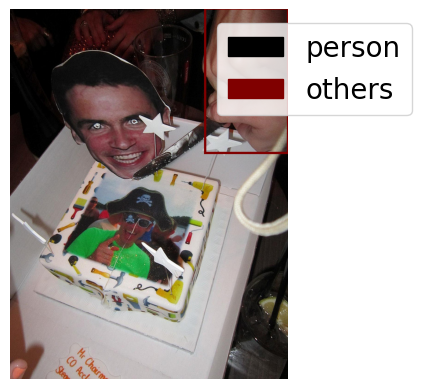

In [40]:
from PIL import Image, ImageDraw
img_copy_test = img.copy()

idx = best_id
#print((processed_new_bbox[i][j]))
#topLeft = (prop_rects[idx][0],prop_rects[idx][1])
#bottomRight = (prop_rects[idx][2],prop_rects[idx][3])
img2 = ImageDraw.Draw(img_copy_test)
#rect_color = getHexColor(rgba_cols[i])
draw_rectangle(img2, (topLeft_new,botRight_new),color = tuple(rgba_cols[i]), width=4)
#draw_rectangle(img1, (topLeft,bottomRight),color = "red", width=2)
plt.axis('off')
plt.imshow(img_copy_test)
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
#**TODO** IOU, remember to check for size difference
#plt.figure()
#refer.showRef(ref, seg_box='box')
#plt.show()

In [37]:
new_bbox_xywh = [topLeft_new[0], topLeft_new[1], botRight_new[0]-topLeft_new[0], botRight_new[1]-topLeft_new[1]]
ref_bbox = refer.refToAnn[ref_id]['bbox']
IoU = computeIoU(ref_bbox, new_bbox_xywh)
IoU

0.0